In [2]:
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
import pymc as pm
import pytensor
pytensor.config.floatX = "float32"
import jax
#os.environ["JAX_ENABLE_X64"] = "True"  # Enable double precision in JAX
#jax.config.update("jax_enable_x64", True)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# get data
API_KEY = os.getenv("API_KEY")
url = 'https://data-service.beatthebookie.blog/data'
headers = {"x-api-key": API_KEY}

# Function to fetch data for a specific division and season
def fetch_data(division, season):
    params = {
        'division': division,
        'season': season
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.read_json(io.StringIO(response.content.decode('utf-8')))
    else:
        print(f"Error fetching {division} {season}: {response.status_code}")
        print(response.content.decode('utf-8'))
        return pd.DataFrame()

# Fetch data for all combinations
seasons = ['2024_2025', '2023_2024']
divisions = ['Premier League', 'Championship']
dataframes = []

for division in divisions:
    for season in seasons:
        df = fetch_data(division, season)
        if not df.empty:
            dataframes.append(df)

# Combine all dataframes
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    
    # Convert match_date to datetime
    df['match_date'] = pd.to_datetime(df['match_date'])

df

,division_id,division,season_id,season,match_date,match_teams,home_team_id,home_team,away_team_id,away_team,...,away_xgoals,home_deep,away_deep,home_ppda,away_ppda,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds
0,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-16,Man United - Fulham,f2b82cdbdadf9d3ec47c3a6be66dcfad,Man United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,0.418711,7.0,3.0,7.379310,10.833333,1.60,4.20,5.25,2.50,1.53
1,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Everton - Brighton,6414a61d98ab23b6d757e888ab17a66a,Everton,0d84883ca72c88cb53c8a38262efdcbc,Brighton,...,1.790830,4.0,5.0,18.333333,7.916667,2.63,3.30,2.63,2.00,1.80
2,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Ipswich - Liverpool,e4f63bf6d6d2cd121e6c8e59bef68209,Ipswich,afce84ff226407a47c9782a742ba02f7,Liverpool,...,3.929060,2.0,13.0,18.777778,8.739130,8.50,5.50,1.33,3.00,1.40
3,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Nott'm Forest - Bournemouth,9a8e1e9fad8766fc3d69a0c26d98b928,Nott'm Forest,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,...,1.909150,10.0,4.0,8.653846,9.954545,2.45,3.50,2.80,2.10,1.73
4,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Newcastle - Southampton,78e9266876e7649e0a12e3840f5be006,Newcastle,5a884401673693b0bdf379fefb7ec2b2,Southampton,...,1.954830,4.0,13.0,16.250000,3.789474,1.36,5.25,8.00,3.00,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Sunderland - Sheffield Weds,1820e986a8a213df782c5cf5ad0b65e1,Sunderland,ec5c8ee83966ae3a295abeee6ab46871,Sheffield Weds,...,1.300000,NaN,NaN,NaN,NaN,2.70,3.40,2.55,1.80,2.00
1641,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Rotherham - Cardiff,095ea4179483dfdd7fd4ee61a25954f4,Rotherham,288a6430a6f57a76e823d74e0dd750d2,Cardiff,...,1.300000,NaN,NaN,NaN,NaN,3.40,3.40,2.20,1.73,2.10
1642,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Leicester - Blackburn,a06360acafe964d244e424cbd50862e8,Leicester,8178de69a5e17f7bbe3a74331977feb1,Blackburn,...,1.700000,NaN,NaN,NaN,NaN,1.70,3.75,5.25,2.50,1.53
1643,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Plymouth Argyle - Hull,a0111c6b8f3812f2e36ababf2c032d8c,Plymouth Argyle,63b0fc998685327831f96bbe7b07b7e2,Hull,...,0.500000,NaN,NaN,NaN,NaN,3.50,3.75,2.00,2.30,1.62


In [65]:
def build_model(matches_df):
    # Get unique teams
    teams = sorted(set(matches_df['home_team']).union(set(matches_df['away_team'])))
    n_teams = len(teams)
    team_indices = {team: idx for idx, team in enumerate(teams)}
    
    # Create indices for home and away teams
    home_idx = np.array([team_indices[team] for team in matches_df['home_team']], dtype=np.int64)
    away_idx = np.array([team_indices[team] for team in matches_df['away_team']], dtype=np.int64)
    
    # Observed goals
    home_goals = matches_df['home_goals'].values.astype(np.float64)
    away_goals = matches_df['away_goals'].values.astype(np.float64)

    # Calculate days since most recent match
    dates = pd.to_datetime(matches_df['match_date'])
    max_date = dates.max()
    days_since = (max_date - dates).dt.days.values.astype(np.float64)

    n_obs = len(days_since)
    
    with pm.Model() as model:
        decay_rate = pm.Gamma('decay_rate', alpha=12, beta=4000)


        time_weights = pm.math.exp(-decay_rate * days_since)
        normalized_weights = time_weights / pm.math.sum(time_weights) * n_obs

        # The rest of your model...
        home_adv = pm.Normal('home_adv', mu=0.2, sigma=0.2)
        attack = pm.ZeroSumNormal('attack', sigma=0.5, shape=n_teams)
        defense = pm.ZeroSumNormal('defense', sigma=0.5, shape=n_teams)

        home_goals_lambda = pm.math.exp(home_adv + attack[home_idx] + defense[away_idx])
        away_goals_lambda = pm.math.exp(attack[away_idx] + defense[home_idx])
        
        # Calculate log probabilities
        home_rv = pm.Poisson.dist(mu=home_goals_lambda)
        away_rv = pm.Poisson.dist(mu=away_goals_lambda)
        
        home_logp = pm.logp(home_rv, home_goals)
        away_logp = pm.logp(away_rv, away_goals)
        
        # Create potentials with weighted sum
        pm.Potential('weighted_home_likelihood', (home_logp * normalized_weights).sum())
        pm.Potential('weighted_away_likelihood', (away_logp * normalized_weights).sum())

        os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz-12.2.1-win64\bin'
        graph = pm.model_to_graphviz(model)
        display(graph)

    return model

def sample_model(model, draws=1000, tune=1000, chains=4, cores=None):
    with model:
        # Use sample_numpyro_nuts instead
        trace = pm.sample(
            nuts_sampler='numpyro',
            draws=draws,
            tune=tune,
            chains=chains,
        )
    return trace


In [77]:
def plot_team_strengths(trace, teams):
    """Plot the attack and defense strengths of teams"""
    attack = az.summary(trace.posterior.attack, kind="stats")["mean"].values
    defense = az.summary(trace.posterior.defense, kind="stats")["mean"].values
    
    # Create a dataframe for plotting
    team_strengths = pd.DataFrame({
        'Team': teams,
        'Attack': attack,
        'Defense': defense
    })
    
    # Calculate overall strength (high attack, low defense is better)
    # Subtract defense to penalize bad defense
    team_strengths['Overall'] = team_strengths['Attack'] - team_strengths['Defense']
    
    # Sort by different metrics
    team_strengths_attack = team_strengths.sort_values('Attack', ascending=False)
    team_strengths_defense = team_strengths.sort_values('Defense', ascending=True)
    team_strengths_overall = team_strengths.sort_values('Overall', ascending=False)
    
    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    
    # Attack plot
    team_strengths_attack.plot.bar(x='Team', y='Attack', ax=ax1, color='skyblue')
    ax1.set_title('Team Attack Strengths')
    ax1.set_ylabel('Attack Parameter (higher is better)')
    ax1.tick_params(axis='x', labelrotation=90)
    
    # Defense plot
    team_strengths_defense.plot.bar(x='Team', y='Defense', ax=ax2, color='salmon')
    ax2.set_title('Team Defense Strengths')
    ax2.set_ylabel('Defense Parameter (lower is better)')
    ax2.tick_params(axis='x', labelrotation=90)
    
    # Overall Strength plot
    team_strengths_overall.plot.bar(x='Team', y='Overall', ax=ax3, color='green')
    ax3.set_title('Team Overall Strengths')
    ax3.set_ylabel('Overall Strength (Attack - Defense)')
    ax3.tick_params(axis='x', labelrotation=90)
    
    plt.tight_layout()
    return fig

In [67]:
def check_convergence(trace):
    # 1. Summary including R-hat and ESS
    summary = az.summary(trace)
    print("R-hat values > 1.05:")
    print(summary[summary['r_hat'] > 1.05])
    
    # 2. Trace plots
    ax = az.plot_trace(trace, var_names=['home_adv', 'decay_rate', 'attack', 'defense'], 
                      compact=True)
    fig = ax[0, 0].figure
    fig.tight_layout()
    
    # 3. Energy plot
    energy_fig = az.plot_energy(trace)
    
    # 4. Rank plots (checks exchangeability of chains)
    rank_fig = az.plot_rank(trace, var_names=['home_adv'])
    
    # 5. Detailed diagnostics
    diagnostics = {
        'divergences': trace.sample_stats.diverging.sum().item(),
        'min_ess': summary['ess_bulk'].min(),
        'max_rhat': summary['r_hat'].max()
    }
    
    return {
        'summary': summary,
        'trace_fig': fig,
        'energy_fig': energy_fig,
        'rank_fig': rank_fig,
        'diagnostics': diagnostics
    }


In [68]:
def check_goodness_of_fit(trace, teams, test_data):
    team_mapping = {team: idx for idx, team in enumerate(teams)}

    home_idx = np.array([team_mapping[team] for team in test_data["home_team"]])
    away_idx = np.array([team_mapping[team] for team in test_data["away_team"]])

    actual_home_goals = test_data["home_goals"].values
    actual_away_goals = test_data["away_goals"].values

    # Get all posterior samples
    home_adv_samples = trace.posterior["home_adv"].values.flatten()
    attack_samples = trace.posterior["attack"].values.reshape(-1, len(teams))
    defense_samples = trace.posterior["defense"].values.reshape(-1, len(teams))
    
    # Number of posterior samples
    n_samples = len(home_adv_samples)
    
    # Initialize arrays to store predictions for each sample
    pred_home_goals = np.zeros((n_samples, len(test_data)))
    pred_away_goals = np.zeros((n_samples, len(test_data)))
    
    # Calculate predictions for each posterior sample
    for i in range(n_samples):
        pred_home_goals[i] = np.exp(home_adv_samples[i] + attack_samples[i, home_idx] + defense_samples[i, away_idx])
        pred_away_goals[i] = np.exp(attack_samples[i, away_idx] + defense_samples[i, home_idx])
    
    # Calculate mean predictions across all samples
    mean_pred_home_goals = pred_home_goals.mean(axis=0)
    mean_pred_away_goals = pred_away_goals.mean(axis=0)
    
    # Calculate MAE
    home_mae = mean_absolute_error(actual_home_goals, mean_pred_home_goals)
    away_mae = mean_absolute_error(actual_away_goals, mean_pred_away_goals)
    combined_mae = (home_mae + away_mae) / 2

    return home_mae, away_mae, combined_mae, pred_home_goals, pred_away_goals

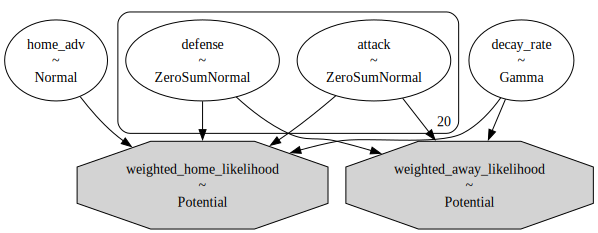

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\jax\_src\interpreters\mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float32[4,5000,19]), ShapedArray(float32[4,5000,19]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


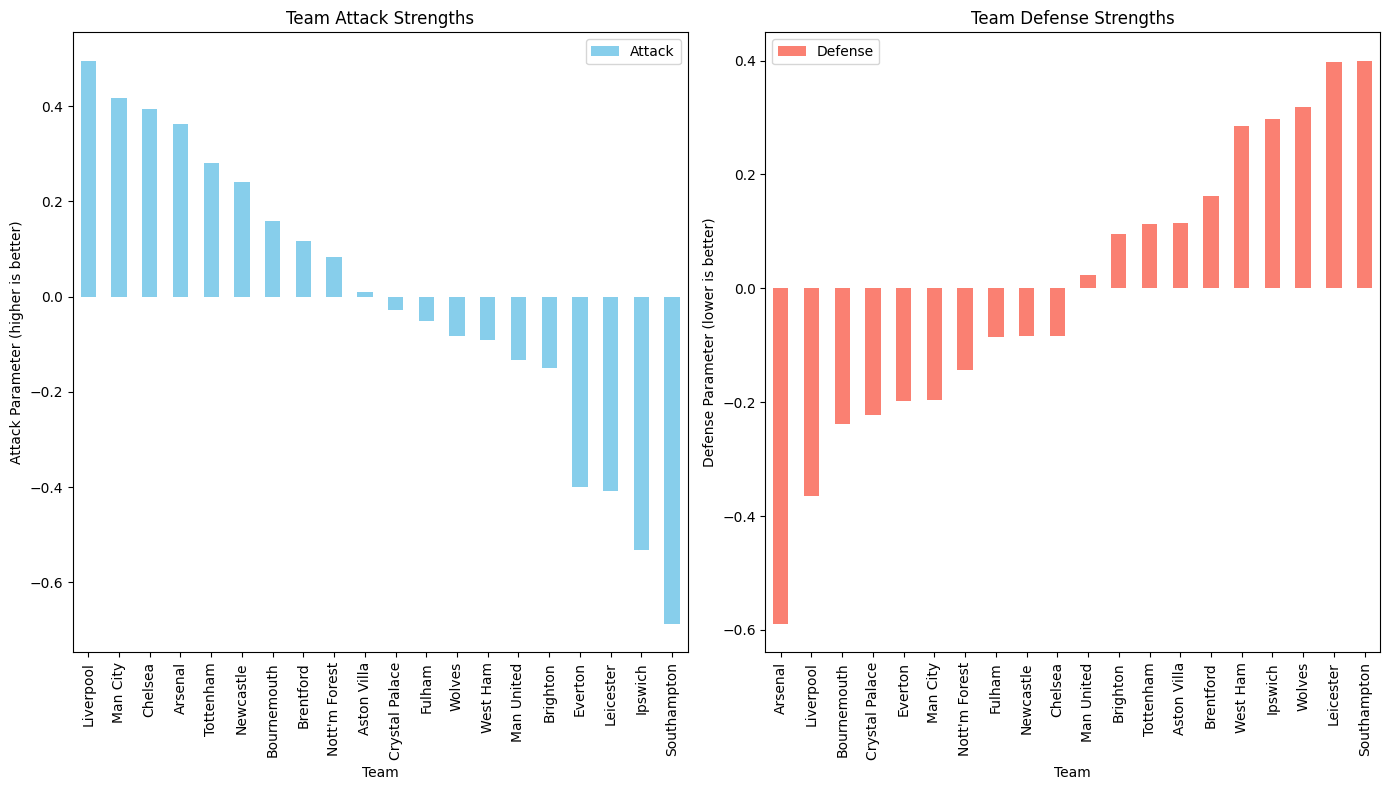

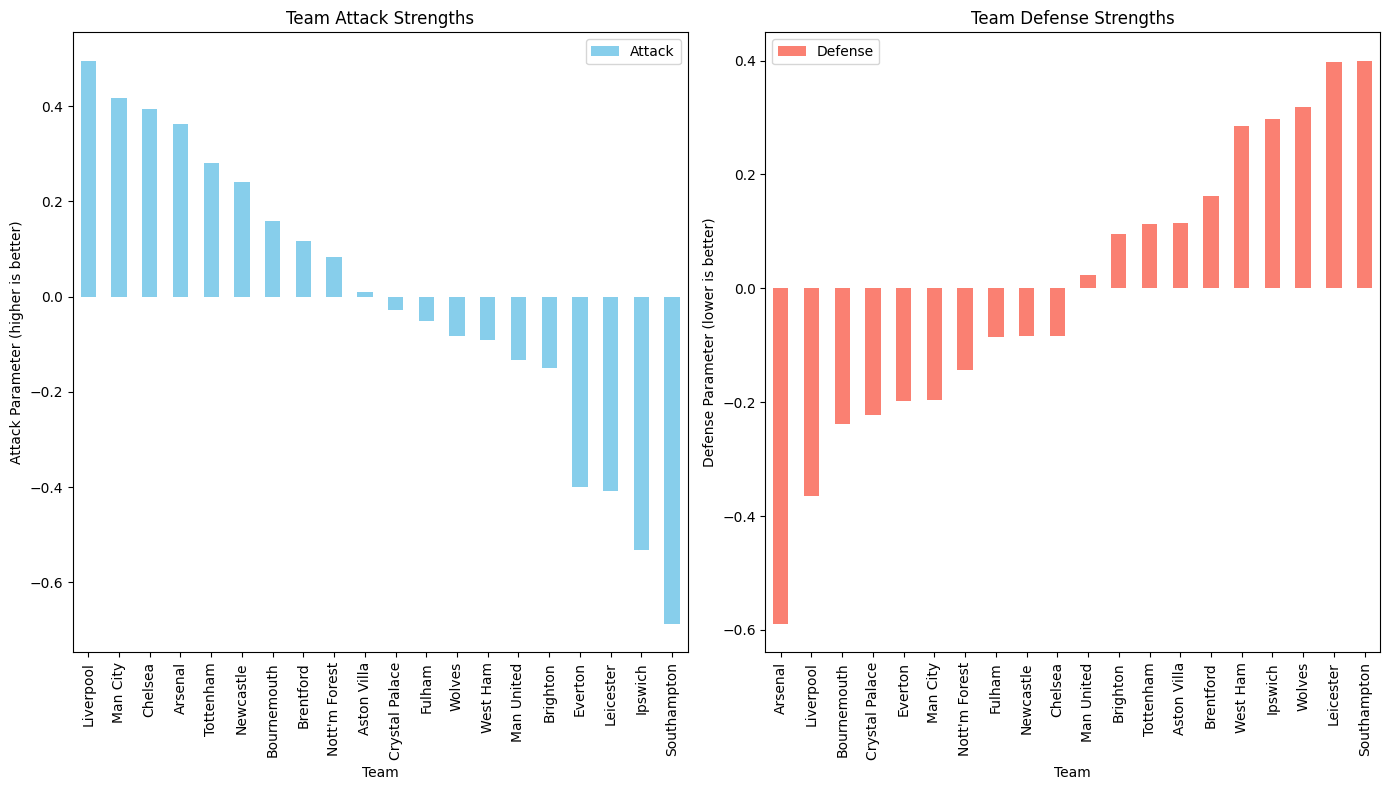

In [ ]:
today = datetime.now()
test_cutoff = today - timedelta(days=30)  # Last 30 days for testing
train_cutoff = today - timedelta(days=395)  # Use ~1 year of data for training

train_df = df[(df['match_date'] > train_cutoff) & (df['match_date'] <= test_cutoff)]

# Get Premier League teams present in 2025
year_2025_start = datetime(2025, 1, 1)
teams_in_2025 = set(
    df[(df['match_date'] >= year_2025_start) & (df['division'] == 'Premier League')]['home_team']
).union(
    set(df[(df['match_date'] >= year_2025_start) & (df['division'] == 'Premier League')]['away_team'])
)

# Filter train_df to only include Premier League matches with teams present in 2025
train_df = train_df[train_df['division'] == 'Premier League']
train_df = train_df[
    train_df['home_team'].isin(teams_in_2025) & 
    train_df['away_team'].isin(teams_in_2025)
]

test_df = df[df['match_date'] > test_cutoff]
test_df = test_df[test_df['division'] == 'Premier League']

train_df = train_df[["match_date", "home_team", "away_team", "home_goals", "away_goals"]]

model = build_model(train_df)
trace = sample_model(model, draws=5000, tune=1000, chains=4)

teams = sorted(set(train_df['home_team']).union(set(train_df['away_team'])))

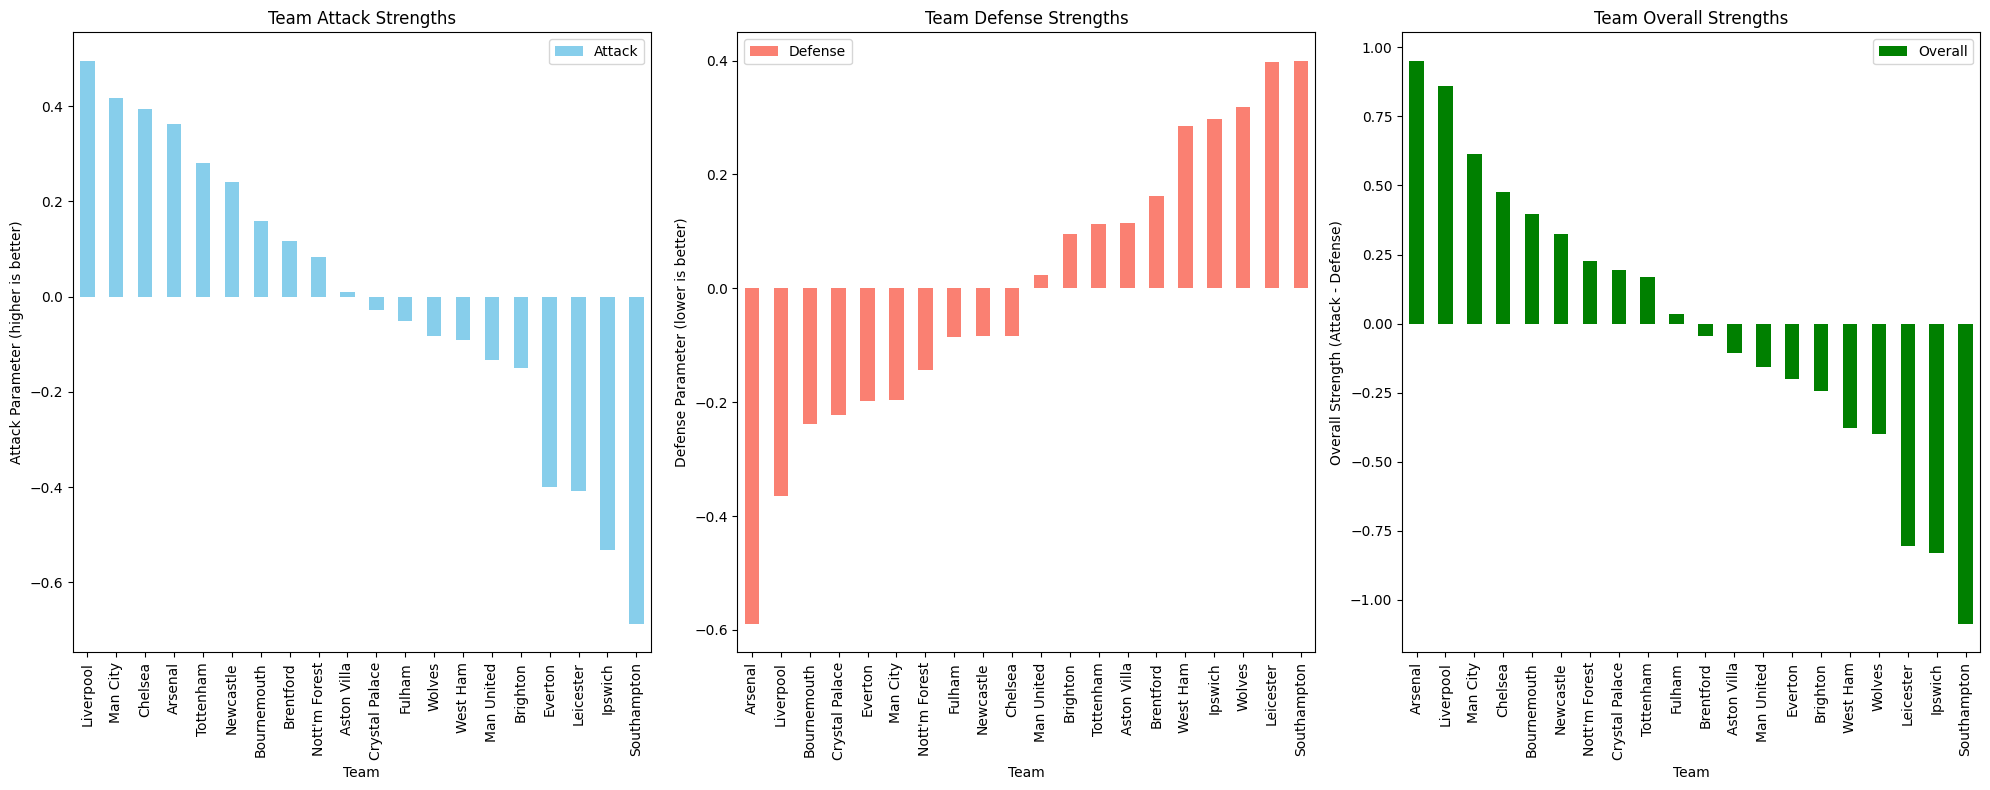

In [78]:
fig = plot_team_strengths(trace, teams)
plt.show(fig)
plt.close(fig)

R-hat values > 1.05:
Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []
{'summary':               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
home_adv     0.365  0.045   0.279    0.449      0.000    0.000   28377.0   
decay_rate   0.002  0.001   0.001    0.004      0.000    0.000   22630.0   
attack[0]    0.362  0.120   0.141    0.591      0.001    0.001   29935.0   
attack[1]    0.009  0.139  -0.255    0.274      0.001    0.001   31651.0   
attack[2]    0.160  0.134  -0.088    0.416      0.001    0.001   31764.0   
attack[3]    0.117  0.134  -0.131    0.371      0.001    0.001   31073.0   
attack[4]   -0.149  0.152  -0.433    0.139      0.001    0.001   27841.0   
attack[5]    0.395  0.118   0.172    0.618      0.001    0.000   29670.0   
attack[6]   -0.028  0.144  -0.295    0.247      0.001    0.001   32524.0   
attack[7]   -0.400  0.168  -0.731   -0.094      0.001    0.001   32292.0   
attack[8]   -0.052  0

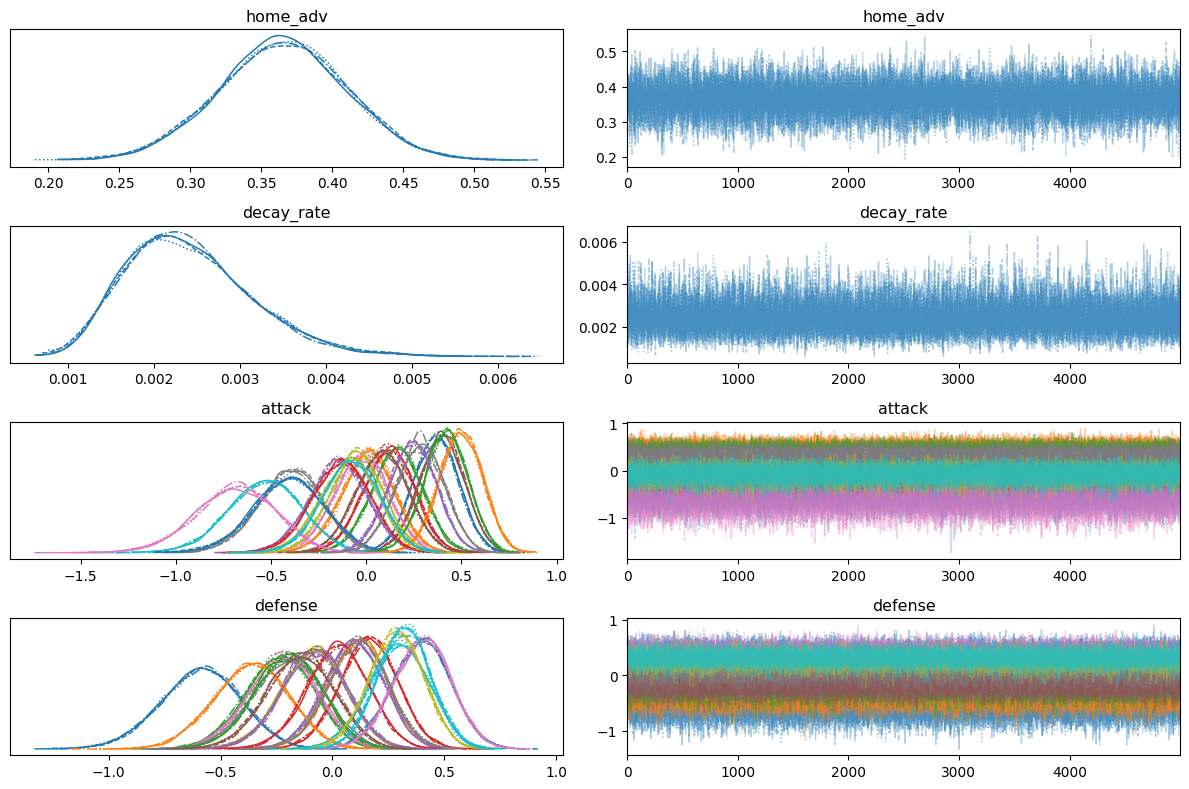

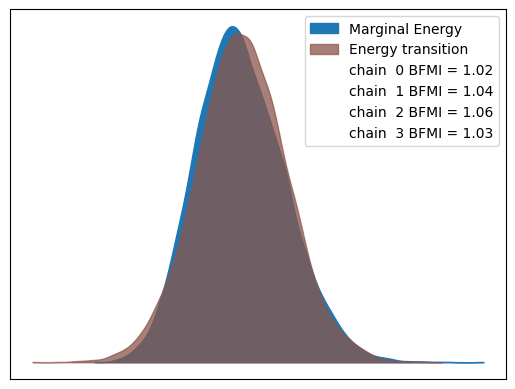

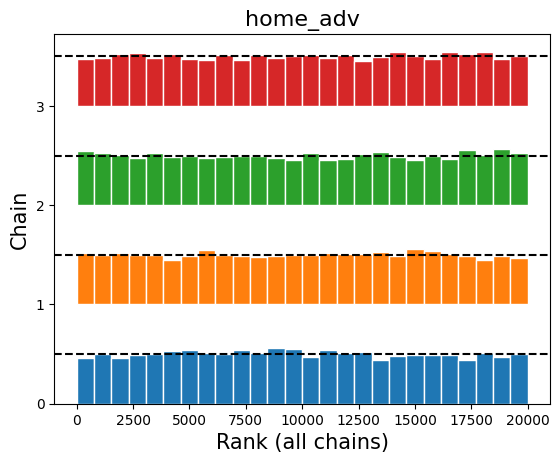

In [73]:
print(check_convergence(trace))

In [74]:
test_df = df[df['match_date'] > test_cutoff]
test_df = test_df[test_df['division'] == 'Premier League']

home_mae, away_mae, combined_mae, pred_home_goalsm, pred_away_goals = check_goodness_of_fit(trace, teams, test_df)
print(f"Home MAE: {home_mae:.2f}")
print(f"Away MAE: {away_mae:.2f}")
print(f"Combined MAE: {combined_mae:.2f}")

Home MAE: 1.05
Away MAE: 0.82
Combined MAE: 0.94
